# Get number of pixels clusters example

In [1]:
%matplotlib inline

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (6, 6)

import os

from IPython.display import display

import ipywidgets
from ipywidgets import interact

from ctapipe.image.hillas import HillasParameterizationError

import pywicta
from pywicta.io import geometry_converter
from pywicta.io.images import image_generator
from pywicta.io.images import plot_ctapipe_image
from pywicta.io.images import plot_hillas_parameters_on_axes
from pywicta.io.images import print_hillas_parameters
from pywicta.io.images import hillas_parameters_to_df
from pywicta.image.hillas_parameters import get_hillas_parameters
from pywicta.denoising import wavelets_mrtransform
from pywicta.denoising.wavelets_mrtransform import WaveletTransform
from pywicta.denoising import inverse_transform_sampling
from pywicta.denoising.inverse_transform_sampling import EmpiricalDistribution

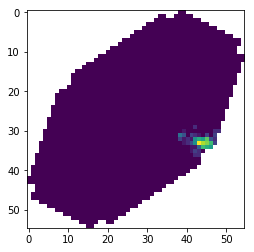

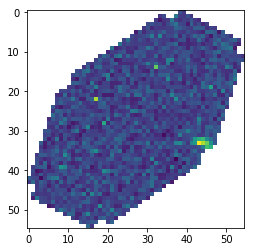

/Users/jdecock/git/pub/jdhp/pywi-cta/pywicta/denoising/cdf/lstcam_grid_prod3b_north_cdf_gamma_mars_like.json


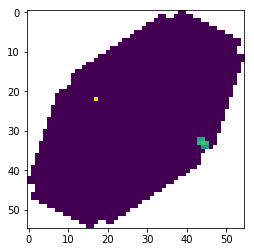

In [2]:
#TMP_DIR = "/Volumes/ramdisk"
TMP_DIR = "."

#cam_id = "ASTRICam"
#cam_id = "CHEC"
#cam_id = "DigiCam"
#cam_id = "FlashCam"
#cam_id = "NectarCam"
cam_id = "LSTCam"

#SIMTEL_FILE = "~/data/astri_mini_array_konrad/simtel/astri_v2/gamma/gamma_20deg_180deg_run2203___cta-prod3-sst-astri_desert-2150m-Paranal-sst-astri2.simtel.gz"
#SIMTEL_FILE = "~/data/gct_mini_array_konrad/simtel/gct/gamma/gamma_20deg_180deg_run2203___cta-prod3-sst-gct_desert-2150m-Paranal-sst-gct.simtel.gz"
#SIMTEL_FILE = "~/data/sst1m_mini_array_konrad/simtel/sst1m/gamma/gamma_20deg_180deg_run2203___cta-prod3-sst-dc_desert-2150m-Paranal-sst-dc.simtel.gz"
SIMTEL_FILE = "~/data/grid_prod3b_north/simtel/gamma/gamma_20deg_0deg_run104___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"

PATHS = [SIMTEL_FILE]
NUM_IMAGES = 1

#rejection_criteria = lambda image: not 50 < np.nansum(image.reference_image) < 200
rejection_criteria = None

integrator = 'LocalPeakIntegrator'
integration_correction = False

if cam_id == "ASTRICam":
    integrator_window_width = 1
    integrator_window_shift = 1
elif cam_id == "CHEC":
    integrator_window_width = 10
    integrator_window_shift = 5
elif cam_id == "DigiCam":
    integrator_window_width = 5
    integrator_window_shift = 2
elif cam_id == "FlashCam":
    integrator_window_width = 6
    integrator_window_shift = 3
elif cam_id == "NectarCam":
    integrator_window_width = 5
    integrator_window_shift = 2
elif cam_id == "LSTCam":
    integrator_window_width = 5
    integrator_window_shift = 2
else:
    raise ValueError('Unknown cam_id "{}"'.format(cam_id))

integrator_t0 = None
integrator_sig_amp_cut_hg = None
integrator_sig_amp_cut_lg = None
integrator_lwt = None

it = image_generator(PATHS,
                     max_num_images=NUM_IMAGES,
                     cam_filter_list=[cam_id],
                     ctapipe_format=False,
                     time_samples=False,
                     rejection_criteria=rejection_criteria,
                     integrator=integrator,
                     integrator_window_width=integrator_window_width,
                     integrator_window_shift=integrator_window_shift,
                     integrator_t0=integrator_t0,
                     integrator_sig_amp_cut_hg=integrator_sig_amp_cut_hg,
                     integrator_sig_amp_cut_lg=integrator_sig_amp_cut_lg,
                     integrator_lwt=integrator_lwt,
                     integration_correction=integration_correction)

for image in it:
    plt.imshow(image.reference_image)
    plt.show()
    
    plt.imshow(image.input_image)
    plt.show()
    
    # Fill blank pixels with noise
    noise_cdf_file = inverse_transform_sampling.get_cdf_file_path(cam_id)  # pywicta.denoising.cdf.LSTCAM_CDF_FILE
    print(noise_cdf_file)
    noise_distribution = EmpiricalDistribution(noise_cdf_file)
    
    # Image cleaning with Wavelets
    wavelet = WaveletTransform()
    cleaned_image = wavelet.clean_image(image.input_image,
                                        type_of_filtering = 'hard_filtering',
                                        filter_thresholds = [8, 2],            # <- TODO
                                        last_scale_treatment = "mask",
                                        detect_only_positive_structures = False,
                                        kill_isolated_pixels = False,
                                        noise_distribution = noise_distribution,
                                        tmp_files_directory = TMP_DIR)
    
    plt.imshow(cleaned_image)
    plt.show()